In [1]:
import numpy as np
import torch.nn as nn
import torch
from tqdm import tqdm
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
"""
Main goal of this project is mathching simple distribution(Gaussian) to more complexed one(Checkerboard)
by using Flow matching, and meanwhile I will visualize it step by step to understand about it
"""

# step 1 : Visualize dataset
def my_gaussian(batch_size) :
  # generate random dataset with size of (batchsize,2) based on normal distribution having mean 0 and sd 1
  return torch.randn(batch_size,2)


def my_checkerboard(batch_size):
  # sample generated uniformly in range [-2,2] in x_axis
  x = torch.rand(batch_size)*4 -2
  # before making y axis, it is preporcessed step. it makes sample centered roughly around -2 or -1
  # it is because to seperate odd and even column
  p_y =  torch.rand(batch_size) - torch.randint(high=2,size = (batch_size,)) * 2
  # and then we also need to consider x_axis, if it is odd row, you have to up it to make checker pattern
  y = p_y + (torch.floor(x) % 2)

  data = 1.0 * torch.cat([x[:,None], y[:,None]], dim=1) / 0.45

  return data.float()




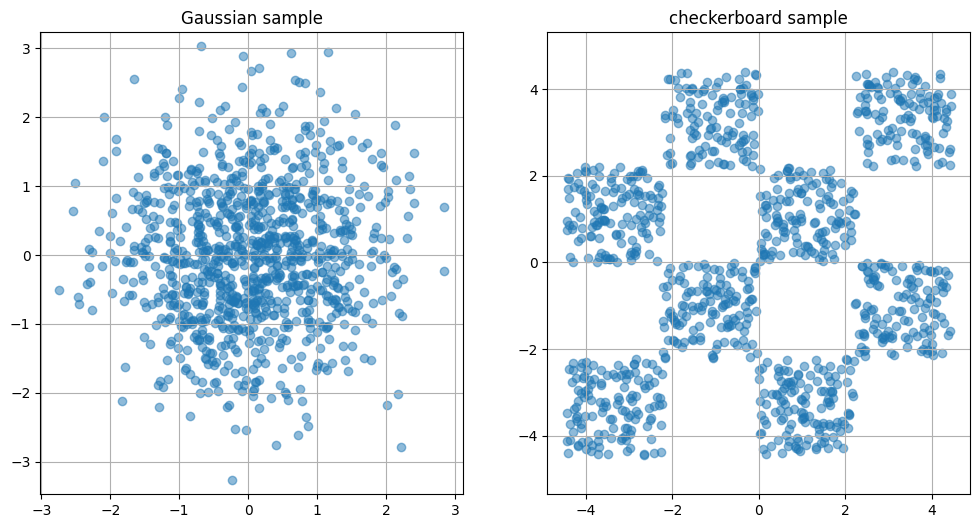

In [10]:
# create samples from each distribution
gu_sample = my_gaussian(1000)
ch_sample = my_checkerboard(1000)

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.scatter(gu_sample[:,0], gu_sample[:,1], alpha =0.5)
plt.title("Gaussian sample")
plt.axis("equal")
plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(ch_sample[:,0],ch_sample[:,1], alpha = 0.5)
plt.title("checkerboard sample")
plt.axis("equal")
plt.grid(True)

plt.show()


In [11]:
# now, I would like to make Flow matching model

class Flowmacthing(nn.Module):
  def __init__(self, input_dim = 2, t_emd_dim = 64) :
    super().__init__()
#In flow matching, we need to predict velocity field f(x,t), which means model behave differently
#depending on time series, 0 is starting point, 1 is target(real data). By passing t through MLP
#we lift up to high dimensial representation

    self.t_emd = nn.Sequential(
        nn.Linear(1,t_emd_dim),
        nn.SiLU(), # sigmoid linear unit
        nn.Linear(t_emd_dim,t_emd_dim)
    )

   # main nextwork for predicting velocity
    self.net = nn.Sequential(
        nn.Linear(input_dim + t_emd_dim,128), # concetenation between time and distribution as input
        nn.SiLU(),
        nn.Linear(128,128),
        nn.SiLU(),
        nn.Linear(128,128),
        nn.SiLU(),
        nn.Linear(128,128),
        nn.SiLU(),
        nn.Linear(128,128),
        nn.SiLU(),
        nn.Linear(128,input_dim)
   )

  def forward(self,x,t):
    t_emd = self.t_emd(t)
    xt = torch.cat([x,t_emd], dim = 1)

    return self.net(xt)





In [16]:
# now calculate Loss

def f_loss(model,x0,x1,t):
  # calculate the point along the trajectory for each t
  xt = (1-t) * x0 + t*x1
  # ground truth when to do derivative to xt(constant)
  v_target = x1-x0
  # prdeict the velocity
  v_pred = model(xt,t)

  return ((v_pred - v_target)**2).mean()

In [17]:
step = 10000
batch_size = 512
losses =[]

model = Flowmacthing().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

for step in tqdm(range(step)):
  # genearte sample of source,target,and t[0,1]
  source = my_gaussian(batch_size).to(device)
  target = my_checkerboard(batch_size).to(device)
  t = torch.rand(batch_size,1).to(device)

  loss = f_loss(model,source,target,t)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  losses.append(loss.item())


  if step % 1000 == 0:
    print(f"Step {step} | Loss: {loss.item():.4f}")





  1%|          | 69/10000 [00:00<00:29, 338.36it/s]

Step 0 | Loss: 7.1436


 11%|█         | 1063/10000 [00:03<00:27, 327.90it/s]

Step 1000 | Loss: 3.9416


 21%|██        | 2061/10000 [00:06<00:24, 327.25it/s]

Step 2000 | Loss: 4.0085


 30%|███       | 3048/10000 [00:09<00:21, 328.87it/s]

Step 3000 | Loss: 3.9059


 40%|████      | 4038/10000 [00:12<00:17, 339.64it/s]

Step 4000 | Loss: 3.8478


 50%|█████     | 5037/10000 [00:16<00:15, 328.91it/s]

Step 5000 | Loss: 4.2298


 61%|██████    | 6065/10000 [00:19<00:11, 332.93it/s]

Step 6000 | Loss: 3.8166


 70%|███████   | 7034/10000 [00:22<00:09, 328.17it/s]

Step 7000 | Loss: 3.8165


 80%|████████  | 8024/10000 [00:25<00:07, 276.63it/s]

Step 8000 | Loss: 3.9573


 91%|█████████ | 9063/10000 [00:28<00:02, 329.12it/s]

Step 9000 | Loss: 3.6481


100%|██████████| 10000/10000 [00:31<00:00, 315.33it/s]


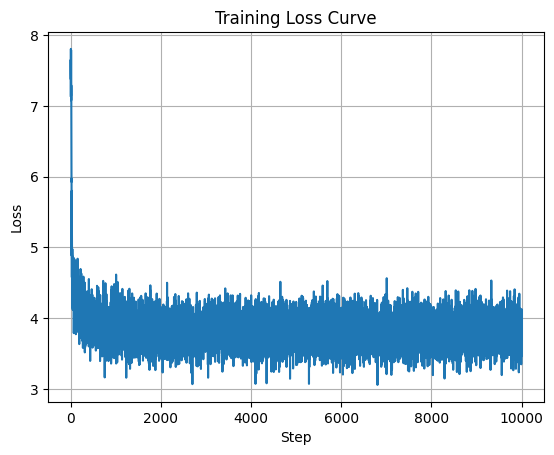

In [18]:
# Plot after training
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

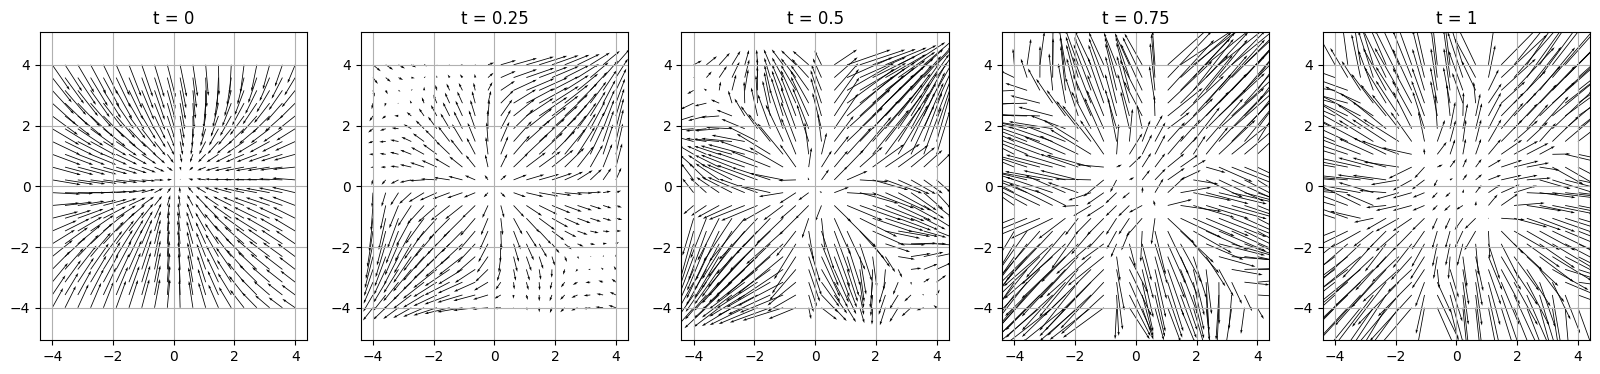

In [26]:
# now visualize how to move form source to target

model.eval()
times = [0, 0.25, 0.5, 0.75, 1]
grid_size = 20
with torch.no_grad():
  fig,axes = plt.subplots(1,len(times), figsize=(4*len(times),4))
  x = np.linspace(-4,4,grid_size)
  y = np.linspace(-4,4,grid_size)
  xx,yy = np.meshgrid(x,y)
  xy = np.stack([xx.flatten(),yy.flatten()],axis = 1)
  xt = torch.tensor(xy, dtype=torch.float32).to(device)

  for i,t in enumerate(times):
    tt = torch.full((xt.shape[0],1), t, dtype=torch.float32).to(device)
    # predict velocity vectors
    v = model(xt,tt).cpu().numpy()

    # plot velocity vectors
    ax = axes[i]
    # compute arrows
    ax.quiver(xx,yy,
              v[:,0].reshape(grid_size, grid_size),
              v[:,1].reshape(grid_size, grid_size),
              scale=20
              )
    ax.set_title(f"t = {t}")
    ax.axis("equal")
    ax.grid(True)

  plt.show()




In [35]:
#sampling

def sampling(model,x0,t_values=(0,1)):
  def ode(t,x):
    # convert x,t to tersor, especially extending dimension in x
    tensor_x = torch.tensor(x, dtype = torch.float32).unsqueeze(0).to(device)
    tensor_t = torch.tensor([[t]], dtype = torch.float32).to(device)
# define not to use gradient for saving memory
    with torch.no_grad():
      v = model(tensor_x,tensor_t)

    return v.squeeze(0).cpu().numpy()
  result  =solve_ivp(ode, t_values, x0.cpu().numpy(), t_eval =[t_values[1]])

  return result.y[:,-1]

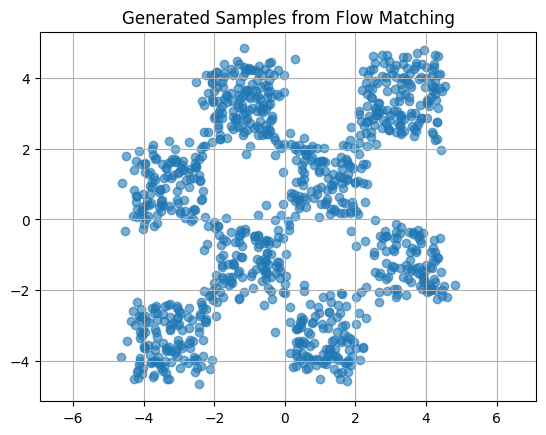

In [36]:
samples = []

# Sample 1000 points from the source distribution p₀
x0 = my_gaussian(1000).to(device)

# Push each point through the learned flow to generate a sample from p₁
for x in x0:
    with torch.no_grad():
        x = x.to(device)
        x1_hat = sampling(model, x, t_values=(0, 1))  # Integrate flow from t=0 to t=1
        samples.append(x1_hat)

# Convert list of sampled points to NumPy array for plotting
samples = np.array(samples)

# Scatter plot of generated samples in 2D
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.6)
plt.title("Generated Samples from Flow Matching")
plt.axis("equal")
plt.grid(True)
plt.show()

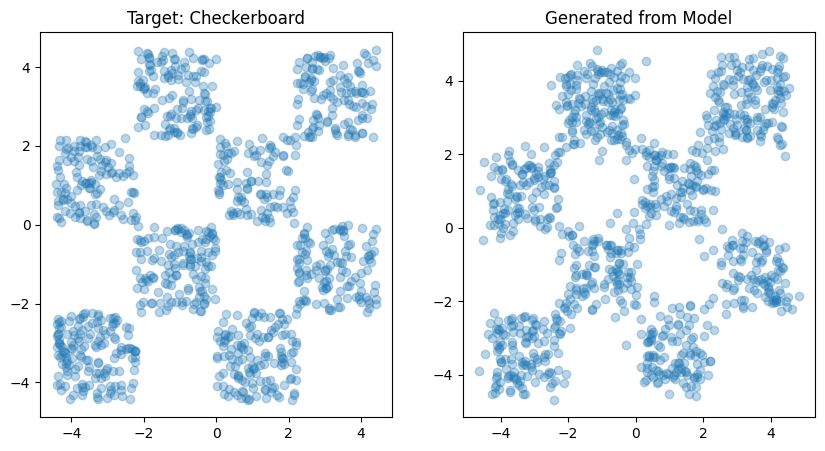

In [38]:
real = my_checkerboard(1000)
gen = np.array(samples)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(real[:, 0], real[:, 1], alpha=0.3)
plt.title("Target: Checkerboard")

plt.subplot(1, 2, 2)
plt.scatter(gen[:, 0], gen[:, 1], alpha=0.3)
plt.title("Generated from Model")

plt.show()